## InceptionV3 Model Training Porocess

### Import libraries

In [1]:
import numpy as np
import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from time import time
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

### Dataset paths

In [2]:
train_path = 'new_augmentation/train'
valid_path = 'new_augmentation/val'
test_path = 'new_augmentation/test'

### Training classes

In [3]:
train_classes = os.listdir(train_path)
train_classes

['Duryodhan',
 'Ganga',
 'Lali',
 'Parashuram',
 'Raju',
 'Sivilbahadur',
 'Sonu',
 'Tirathram',
 'Yoglaxmi']

### Training batch sizes

In [4]:
train_batch_size = 16
test_batch_size = 16
valid_batch_size = 16

### Training samples

In [5]:
# Count the number of samples in each directory
train_n = sum([len(files) for r, d, files in os.walk(train_path)])
test_n = sum([len(files) for r, d, files in os.walk(test_path)])
valid_n = sum([len(files) for r, d, files in os.walk(valid_path)])

print(f'Training samples: {train_n}')
print(f'Test samples: {test_n}')
print(f'Validation samples: {valid_n}')

Training samples: 1212
Test samples: 458
Validation samples: 457


In [6]:
train_n = 1212
test_n = 458
valid_n = 457

### Training steps (per epoch)

In [7]:
train_steps = train_n//train_batch_size
valid_steps = valid_n//valid_batch_size
test_steps = test_n//test_batch_size

### Epochs

In [8]:
epochs = 1000

### Generate batches

In [9]:
train_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(train_path, target_size=(128,128), classes=train_classes, batch_size=train_batch_size)
valid_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(valid_path, target_size=(128,128), classes=train_classes, batch_size=valid_batch_size)
test_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(test_path, target_size=(128,128), classes=train_classes, batch_size=test_batch_size)

Found 1212 images belonging to 9 classes.
Found 457 images belonging to 9 classes.
Found 458 images belonging to 9 classes.


### Base model (InceptionV3)

#### Training from scratch

In [10]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
    weights=None,
    pooling='avg')

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
output =  tf.keras.layers.Dense(len(train_classes), activation='softmax')(base_model.output)
new_model = tf.keras.Model(base_model.input, output)

### Set early stopping
Avoids model overfitting

In [13]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True
)

### Generate new model

In [14]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy"), metrics=['accuracy'])

### Training

In [15]:
history = new_model.fit_generator(train_batches, validation_data=valid_batches, validation_steps=valid_steps, steps_per_epoch=train_steps, epochs=epochs,callbacks=[es_callback])

Epoch 1/1000
75/75 [==============================] - 51s 580ms/step - loss: 2.1696 - accuracy: 0.1438 - val_loss: 2.3989 - val_accuracy: 0.1116
Epoch 2/1000
75/75 [==============================] - 42s 565ms/step - loss: 2.1134 - accuracy: 0.1747 - val_loss: 2.5104 - val_accuracy: 0.1205
Epoch 3/1000
75/75 [==============================] - 41s 550ms/step - loss: 2.0772 - accuracy: 0.2283 - val_loss: 2.2718 - val_accuracy: 0.1585
Epoch 4/1000
75/75 [==============================] - 41s 545ms/step - loss: 2.0450 - accuracy: 0.2734 - val_loss: 2.3285 - val_accuracy: 0.2344
Epoch 5/1000
75/75 [==============================] - 43s 577ms/step - loss: 2.0135 - accuracy: 0.2717 - val_loss: 2.3066 - val_accuracy: 0.1875
Epoch 6/1000
75/75 [==============================] - 37s 487ms/step - loss: 1.9942 - accuracy: 0.2684 - val_loss: 2.3137 - val_accuracy: 0.2321
Epoch 7/1000
75/75 [==============================] - 33s 448ms/step - loss: 1.9589 - accuracy: 0.2542 - val_loss: 2.3260 - val_ac

### Evaluate training process

In [16]:
results = new_model.evaluate_generator(train_batches, train_steps)
results

[1.880228877067566, 0.3774999976158142]

#### Loss function

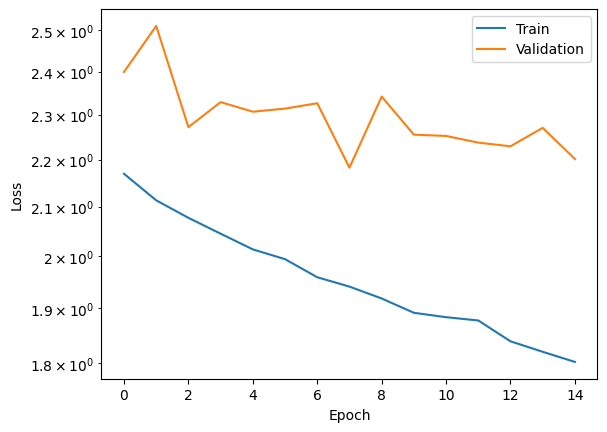

In [17]:
plt.semilogy(history.epoch,  history.history['loss'], label='Train')
plt.semilogy(history.epoch,  history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Accuracy function

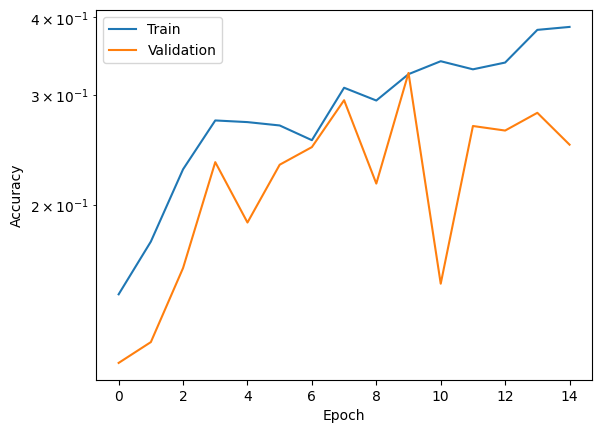

In [18]:
plt.semilogy(history.epoch,  history.history['accuracy'], label='Train')
plt.semilogy(history.epoch,  history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
Y_train_pred =new_model.predict_generator(train_batches,train_steps)

In [20]:
y_train_pred = np.argmax(Y_train_pred, axis=1)

#### Confusion matrix

In [21]:
print(len(train_batches.classes))

1212


In [22]:
y_train_pred = new_model.predict(train_batches, steps=train_steps)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
print(len(y_train_pred_classes))

62/75 [=======================>......] - ETA: 5s

75/75 [==============================] - 31s 413ms/step
1200


In [23]:
# Ensure predictions cover all samples
y_train_pred = new_model.predict(train_batches, steps=train_steps)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Check lengths
print(len(train_batches.classes))  # Should print 1870
print(len(y_train_pred_classes))   # Should print 1870

# Compute confusion matrix
cm_train = confusion_matrix(train_batches.classes, y_train_pred_classes)
cm_train

14/75 [====>.........................] - ETA: 41s

75/75 [==============================] - 40s 523ms/step
1212
1200


ValueError: Found input variables with inconsistent numbers of samples: [1212, 1200]

In [68]:
cm_train = confusion_matrix(train_batches.classes, y_train_pred)

ValueError: Found input variables with inconsistent numbers of samples: [1870, 1856]

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(cm_train, annot=True, fmt="d")
plt.title('Confusion matrix (Train)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Model testing

In [ ]:
Y_pred =new_model.predict_generator(test_batches,test_steps)

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
cm = confusion_matrix(test_batches.classes, y_pred)

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Save model

In [ ]:
new_model.save('InceptionV3_New.h5')